In [2]:
import pandas as pd, re, os, matplotlib.pyplot as plt, numpy as np, collections, itertools, tqdm
import sklearn.metrics as metrics
from statsmodels import api
from scipy import stats
from matplotlib import rcParams
rcParams['font.family'] = "P052"
try:
    pass
    %load_ext autoreload
    %autoreload 2
    %config InlineBackend.figure_format = 'svg'
except SyntaxError:
    pass

os.chdir("/Users/druc594/Library/CloudStorage/OneDrive-PNNL/Desktop/DeepKS_/DeepKS/discovery/nature_atlas/")
THEIR_RANKS_FILE = "./their_ranks.csv"
OUR_RANKS_FILE = "./our_ranks.csv"
normalize_ranks = lambda obj_to_norm, starting_ranks, ending_ranks: obj_to_norm*(ending_ranks-1)/(starting_ranks-1) + (starting_ranks-ending_ranks)/(starting_ranks-1)

In [3]:
their_ranks = pd.read_csv(THEIR_RANKS_FILE, index_col=0)
our_ranks = pd.read_csv(OUR_RANKS_FILE, index_col=0)
their_ranks = normalize_ranks(their_ranks, 303, 10)

In [6]:
K = 3
# Pseudo Confusion Matrix: Cell (X, Y) will be 
# incremented when a site has rank >= K for their kinase X, our kinase Y.
# Initialize np array of zeros, of shape (num_their_kins, num_our_kins)
num_their_kins = len(their_ranks.columns)
num_our_kins = len(our_ranks.columns)
assert num_their_kins == num_our_kins, "The number of kinases in our ranks and their ranks are not the same"
assert K <= num_their_kins, "K is greater than the number of kinases"
assert K <= num_our_kins, "K is greater than the number of kinases"
assert np.all(our_ranks.columns == their_ranks.columns), "Columns are not aligned"
assert np.all(our_ranks.index == their_ranks.index), "Indexes are not aligned"
confusion_matrix = pd.DataFrame(np.zeros((num_their_kins, num_our_kins)))
confusion_matrix.columns = pd.Series(their_ranks.columns).apply(lambda x: x.replace("", ""))
confusion_matrix.index = pd.Index(pd.Series(our_ranks.columns).apply(lambda x: x.replace("", "")))
# Make sure the two dataframes of ranks have indexes exactly the same and aligned
for i, r in tqdm.tqdm(our_ranks.iterrows(), total = len(our_ranks.index)):
    # Get the ranks of the site for each kinase
    assert(isinstance(i, str))
    our_ranks_for_site_argsort = np.argsort(r.values)
    their_ranks_for_site_argsort = np.argsort(their_ranks.loc[i].values)
    for k in range(K):
        our_kth_kinase = our_ranks.columns[our_ranks_for_site_argsort[k]]
        their_kth_kinase = their_ranks.columns[their_ranks_for_site_argsort[k]]
        # Increment the cell (their_kinase, our_kinase) in the confusion matrix
        confusion_matrix.at[our_kth_kinase, their_kth_kinase] += 1
cm = confusion_matrix.values

100%|██████████| 86189/86189 [00:07<00:00, 10953.22it/s]


In [41]:
import random

# random simulation
base = list(range(1, 11))
many_sites_A = [random.sample(base, k=10) for _ in range(86000)]
many_sites_B = [random.sample(base, k=10) for _ in range(86000)]
for c in range(10):
    dist_within_d = 0
    dist_not_within_d = 0
    for i, (t, o) in enumerate(zip(many_sites_A, many_sites_B)):
        if abs(t[c] - o[c]) <= D:
            dist_within_d += 1
        else:
            dist_not_within_d += 1
    print(f"{c=}: {dist_within_d} within {D}, {dist_not_within_d} not within {D}")

c=0: 49841 within 3, 36159 not within 3
c=1: 49676 within 3, 36324 not within 3
c=2: 50125 within 3, 35875 not within 3
c=3: 49815 within 3, 36185 not within 3
c=4: 49848 within 3, 36152 not within 3
c=5: 50211 within 3, 35789 not within 3
c=6: 49990 within 3, 36010 not within 3
c=7: 49894 within 3, 36106 not within 3
c=8: 49816 within 3, 36184 not within 3
c=9: 50064 within 3, 35936 not within 3


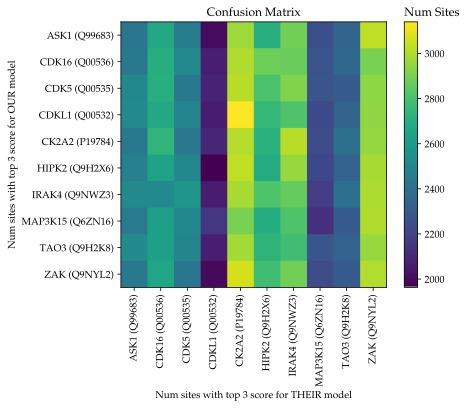

In [18]:
a = metrics.ConfusionMatrixDisplay(cm, display_labels=[x.replace("^Pctl", "").replace("^Rank", "").replace("|['", " (").replace("']", "").replace("['", "") + ")" for x in confusion_matrix.columns.tolist()])
a.plot(include_values=False)
_ = plt.xticks(*plt.xticks(), rotation=90) # type: ignore
_ = plt.ylabel(f"Num sites with top {K} score for OUR model")
_ = plt.xlabel(f"Num sites with top {K} score for THEIR model")
_ = plt.title(f"Confusion Matrix")
# _ = plt.gca().set_title("Num Sites")
plt.gcf().get_children()[2].set_title("Num Sites", loc='left')
plt.savefig("./confusion_mtx.pdf")

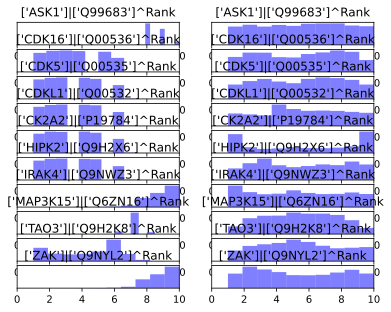

In [ ]:
fig, ax = plt.subplots(nrows=10, ncols=2)
for i, c in enumerate(our_ranks.columns):
    ax[i, 0].hist(our_ranks[c], bins=10, color='blue', alpha=0.5)
    ax[i, 0].set_xlim(0, 10)
    ax[i, 0].set_yticks([], [])
    ax[i, 0].set_title(c)
    # ax[i].set_aspect('equal')
for i, c in enumerate(their_ranks.columns):
    ax[i, 1].hist(their_ranks[c], bins=10, color='blue', alpha=0.5)
    ax[i, 1].set_xlim(0, 10)
    ax[i, 1].set_yticks([], [])
    ax[i, 1].set_title(c)

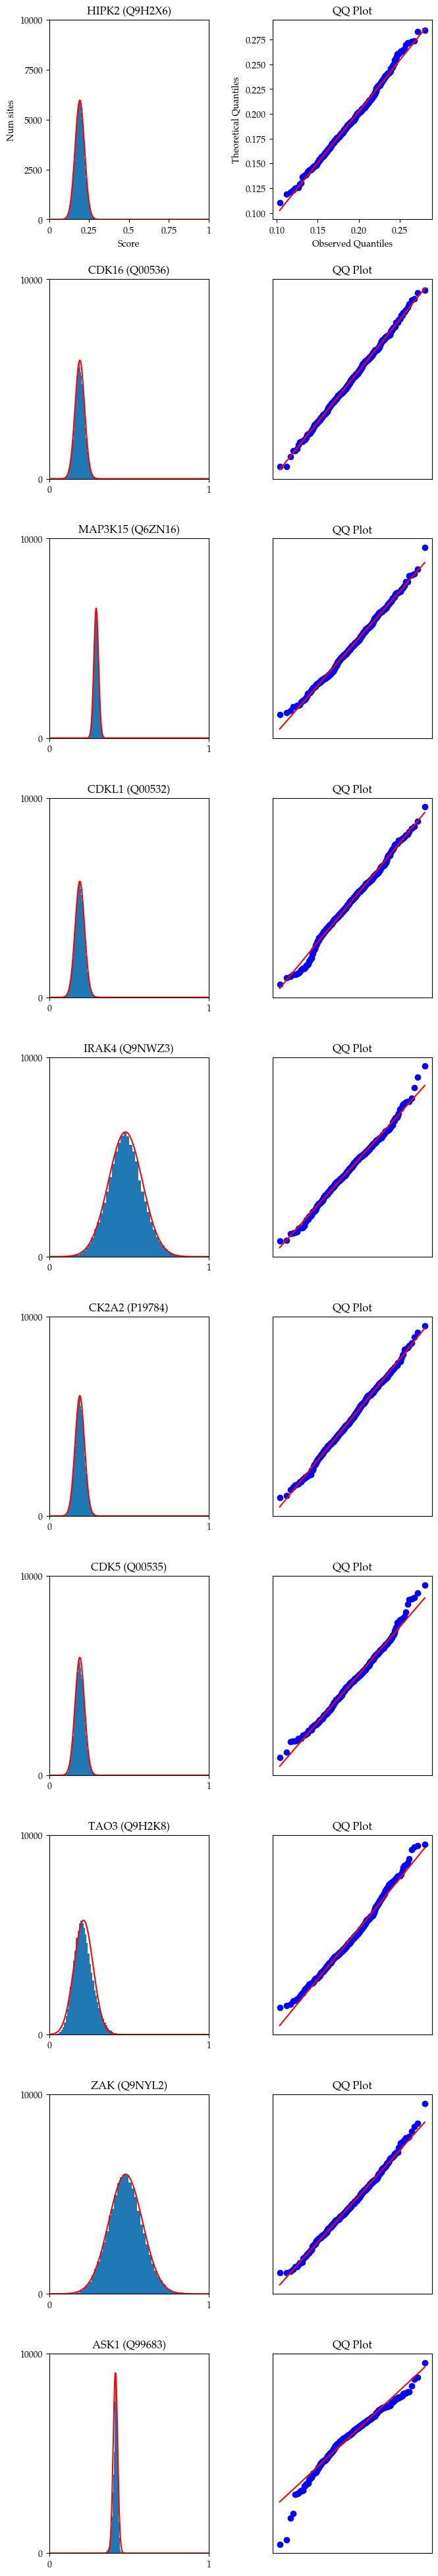

In [ ]:
import random
from scipy.stats.distributions import norm
from scipy import stats
import sys
sys.stderr = open("/dev/null", "w")
%config InlineBackend.figure_format = 'png'

KINS = derived_df.columns
# Check distribution of raw scores for KIN
fig, axs = plt.subplots(nrows=len(KINS), ncols=2, figsize=(7.5, len(KINS)*5), gridspec_kw={'hspace': 0.3, 'wspace': 0.4})
for i, KIN in enumerate(KINS):
    hist_info = axs[i][0].hist(derived_df[KIN], bins=50, density=False)
    _ = axs[i][0].set_xlim(0, 1)
    _ = axs[i][0].set_ylim(0, 10000)
    _ = axs[i][0].set_title(str(KIN).replace("[", "").replace("]", "").replace("'", "").replace(" ", "").replace("^Score", "").replace("|", " (") + ")")
    _ = axs[i][0].set_yticks([], [])
    _ = axs[i][0].set_xlabel("Score" if i == 0 else "")
    _ = axs[i][0].set_ylabel("Num sites" if i == 0 else "")
    _ = axs[i][0].set_yticks([0, 2500, 5000, 7500, 10000] if i == 0 else [0, 10000], [0, 2500, 5000, 7500, 10000] if i == 0 else [0, 10000])
    _ = axs[i][0].set_xticks([0, 0.25, 0.5, 0.75, 1] if i == 0 else [0, 1], [0, 0.25, 0.5, 0.75, 1] if i == 0 else [0, 1])
    max_hist_value = max(hist_info[0])
    X = np.linspace(0, 1, 1000)
    Y = (norm.pdf(np.linspace(0, 1, 1000), loc=np.mean(derived_df[KIN]), scale=np.std(derived_df[KIN]))*len(derived_df[KIN]))
    _ = axs[i][0].plot(X, Y/(max(Y)/max_hist_value), color='red')
    modified_comparison = lambda: norm(loc=np.mean(derived_df[KIN]), scale=np.std(derived_df[KIN]))
    _ = stats.probplot(random.sample(derived_df[KIN].tolist(), k=500), sparams = (np.mean(derived_df[KIN]), np.std(derived_df[KIN])), plot=axs[i][1])
    _ = axs[i][1].set_title("QQ Plot")
    _ = axs[i][1].set_xlabel("Observed Quantiles" if i == 0 else "")
    _ = axs[i][1].set_ylabel("Theoretical Quantiles" if i == 0 else "")
    if i != 0:
        _ = axs[i][1].set_yticks([0, 2500, 5000, 7500, 10000] if i == 0 else [], [0, 2500, 5000, 7500, 10000] if i == 0 else [])
        _ = axs[i][1].set_xticks([0, 0.25, 0.5, 0.75, 1] if i == 0 else [], [0, 0.25, 0.5, 0.75, 1] if i == 0 else [])
plt.savefig("./kinase_score_distributions.pdf", bbox_inches='tight')

In [ ]:
Freedman_Diaconis_rule_n_bins = lambda x: int(round(((max(x) - min(x))/(2*(np.percentile(x, 75) - np.percentile(x, 25))*len(x)**(-1/3))), 0))

In [ ]:
their_results_pctls = their_results[[x for x in their_results.columns if str(x).endswith("_percentile") and not str(x).startswith("median")]]

(array([49., 42., 34., 32., 18., 26., 14., 23., 31., 34.]),
 array([ 0.47 , 10.384, 20.298, 30.212, 40.126, 50.04 , 59.954, 69.868,
        79.782, 89.696, 99.61 ]),
 <BarContainer object of 10 artists>)

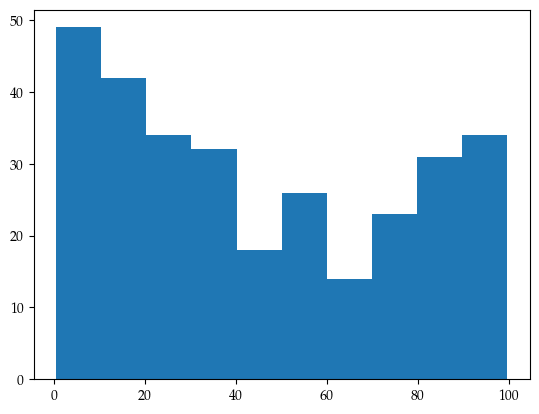

In [ ]:
plt.hist(their_results_pctls.loc["['<UNK>UnipAc:A0A075B6Q4', 'LTV1']|['A0A075B6Q4', 'Q96GA3']|['S24', 'S200']"].iloc[0].values.tolist())